# Dec 31st, 2022 (AD: register N162, round 2)

**Motivation**: run the ANTs loop once again for N162, but now change other params such as syn_metric and aff_metric <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img

mice = Mice(Config(128, resolution=25), load_parcel=True, load_allen=True)
reg = Register(mice)
reg.in_house

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (81, 46, 60)
         Spacing    : (200.0, 200.0, 200.0)
         Origin     : (-7.8, -6.2, 6.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [3]:
reg.nissl.shape

(528, 320, 456)

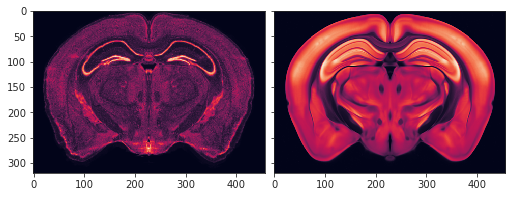

In [6]:
fig, axes = create_figure(1, 2, (7, 3), 'all', 'all', constrained_layout=True)
axes[0].imshow(reg.nissl[300])
axes[1].imshow(reg.template[300])
plt.show()

In [21]:
kwargs = {
    'types': ['SyN', 'ElasticSyN'],
    'grads': [0.25, 0.30, 0.38, 0.45, 0.7],
    'syn_bins': [48, 32, 20],
    'aff_bins': [20, 32, 64],
    'aff_rates': [0.4, 0.8],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.75,
    'n_seeds': 5,
}
kwargs

{
    'types': ['SyN', 'ElasticSyN'],
    'grads': [0.25, 0.3, 0.38, 0.45, 0.7],
    'syn_bins': [48, 32, 20],
    'aff_bins': [20, 32, 64],
    'aff_rates': [0.4, 0.8],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.75,
    'n_seeds': 5
}

In [10]:
reg.set_mode('bold')
reg.mi_base = None

 bad det -1 v 1 u -1
 bad det -1 v 1 u -1 new 1


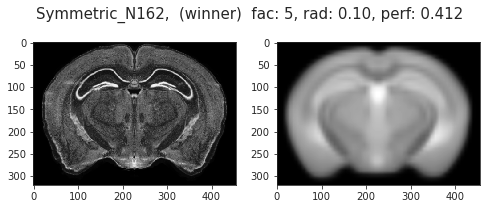

In [ ]:
%%time

results = reg.fit_register(
    name=reg.in_house_name,
    moving=reg.in_house,
    fixed=reg.nissl,
    save_results=True,
    **kwargs,
)

In [5]:
mice.parcel.load_parcel(True)

[
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    False,
    True
]

In [38]:
path = pjoin(mice.cfg.tx_dir, 'cache')
sorted(os.listdir(path))

[
    'perf_Symmetric_N162_(2022_12_29).df',
    'perf_Symmetric_N162_2022_12_20.df',
    'perf_Symmetric_N162_2022_12_21.df',
    'perf_sub-SLC01_ses-2_(2022_04_08).df',
    'perf_sub-SLC02_ses-2_(2022_04_09).df',
    'perf_sub-SLC03_ses-2_(2022_04_10).df',
    'perf_sub-SLC04_ses-2_(2022_04_11).df',
    'perf_sub-SLC05_ses-2_(2022_04_12).df',
    'perf_sub-SLC06_ses-2_(2022_04_13).df',
    'perf_sub-SLC07_ses-2_(2022_04_14).df',
    'perf_sub-SLC08_ses-2_(2022_04_15).df',
    'perf_sub-SLC09_ses-2_(2022_04_15).df',
    'perf_sub-SLC10_ses-2_(2022_04_16).df'
]

In [39]:
df_tx = 'perf_Symmetric_N162_(2022_12_29).df'
df_tx = pd.read_pickle(pjoin(path, df_tx))

In [40]:
df = df_tx.loc[df_tx['metric'].isin(['mi', 'sym'])]
df = df.pivot_table(
    values='score',
    columns='metric',
    index=[c for c in df.columns if c not in ['score', 'metric']],
).reset_index()

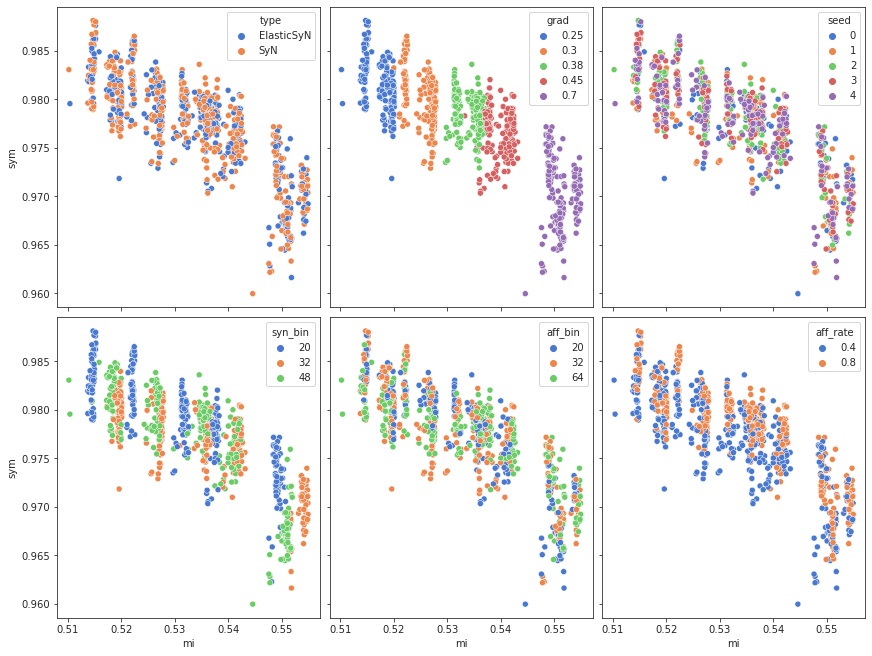

In [41]:
fig, axes = create_figure(2, 3, (12, 9), 'all', 'all', constrained_layout=True)
sns.scatterplot(data=df, x='mi', y='sym', hue='type', palette='muted', ax=axes[0, 0])
sns.scatterplot(data=df, x='mi', y='sym', hue='grad', palette='muted', ax=axes[0, 1])
sns.scatterplot(data=df, x='mi', y='sym', hue='seed', palette='muted', ax=axes[0, 2])
sns.scatterplot(data=df, x='mi', y='sym', hue='syn_bin', palette='muted', ax=axes[1, 0])
sns.scatterplot(data=df, x='mi', y='sym', hue='aff_bin', palette='muted', ax=axes[1, 1])
sns.scatterplot(data=df, x='mi', y='sym', hue='aff_rate', palette='muted', ax=axes[1, 2])

plt.show()

In [63]:
def _bst_tx(name, df_tx, mi_q, verbose=False):
    mi = df_tx.loc[df_tx['metric'] == 'mi']
    sym = df_tx.loc[df_tx['metric'] == 'sym']
    mi = mi.reset_index(drop=True)
    sym = sym.reset_index(drop=True)
    cond = mi['score'] > np.nanquantile(mi['score'], mi_q)
    _df = sym.loc[cond]
    try:
        best_params = _df.iloc[_df['score'].argmax()]
    except ValueError:
        cond = mi['score'] > np.nanquantile(mi['score'], 2 * mi_q / 3)
        _df = sym.loc[cond]
        best_params = _df.iloc[_df['score'].argmax()]
    best_params = best_params.drop(['metric', 'score'])
    best_params = dict(best_params)
    cond = functools.reduce(
        lambda x, y: x & y, [
            df_tx[k] == v for k, v
            in best_params.items()
        ],
    )
    _df = df_tx.loc[cond]
    if verbose:
        msg = f"{name}, perf:\n\n"
        msg += f"{_df.to_string(index=False)}\n"
        print(msg)
    return best_params, _df

In [87]:
best_params, best_df = _bst_tx(reg.in_house_name, df_tx, 0.75)
best_df.loc[best_df['metric'].isin(['mi', 'sym', 'sym_iso'])]

,seed,syn_metric,aff_metric,type,grad,syn_bin,aff_bin,aff_rate,metric,score
18711,3,mattes,mattes,ElasticSyN,0.45,32,32,0.8,mi,0.542096
18735,3,mattes,mattes,ElasticSyN,0.45,32,32,0.8,sym_iso,0.973577
18736,3,mattes,mattes,ElasticSyN,0.45,32,32,0.8,sym,0.980482


In [110]:
df = []
for q in np.linspace(0.1, 0.95, 18):
    best_params, _df = _bst_tx(reg.in_house_name, df_tx, q, False)
    mi = _df.loc[_df['metric'] == 'mi', 'score'].item()
    sym = _df.loc[_df['metric'] == 'sym', 'score'].item()
    data = {
        'mi': mi,
        'sym': sym,
        **best_params,
    }
    print(f"q = {q:0.2f};  mi = {mi:0.3f}, sym = {sym:0.3f}", best_params)
    df.append({
        'q': [np.round(q, 2)] * len(data),
        'label': data.keys(),
        'value': data.values(),
    })
df = pd.DataFrame(merge_dicts(df))

q = 0.10;  mi = 0.522, sym = 0.987
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.3,
    'syn_bin': 20,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.15;  mi = 0.522, sym = 0.987
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.3,
    'syn_bin': 20,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.20;  mi = 0.522, sym = 0.987
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.3,
    'syn_bin': 20,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.25;  mi = 0.522, sym = 0.987
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.3,
    'syn_bin': 20,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.30;  mi = 0.535, sym = 0.984
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.38,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

q = 0.35;  mi = 0.535, sym = 0.984
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.38,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

q = 0.40;  mi = 0.535, sym = 0.984
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.38,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

q = 0.45;  mi = 0.535, sym = 0.984
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.38,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

q = 0.50;  mi = 0.536, sym = 0.982
{
    'seed': 1,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.38,
    'syn_bin': 48,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.55;  mi = 0.538, sym = 0.982
{
    'seed': 1,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.45,
    'syn_bin': 20,
    'aff_bin': 64,
    'aff_rate': 0.8
}

q = 0.60;  mi = 0.538, sym = 0.982
{
    'seed': 1,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.45,
    'syn_bin': 20,
    'aff_bin': 64,
    'aff_rate': 0.8
}

q = 0.65;  mi = 0.538, sym = 0.982
{
    'seed': 1,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.45,
    'syn_bin': 20,
    'aff_bin': 64,
    'aff_rate': 0.8
}

q = 0.70;  mi = 0.542, sym = 0.980
{
    'seed': 3,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.45,
    'syn_bin': 32,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.75;  mi = 0.542, sym = 0.980
{
    'seed': 3,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.45,
    'syn_bin': 32,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.80;  mi = 0.548, sym = 0.977
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.7,
    'syn_bin': 20,
    'aff_bin': 32,
    'aff_rate': 0.8
}

q = 0.85;  mi = 0.550, sym = 0.977
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'SyN',
    'grad': 0.7,
    'syn_bin': 20,
    'aff_bin': 64,
    'aff_rate': 0.8
}

q = 0.90;  mi = 0.552, sym = 0.976
{
    'seed': 0,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 64,
    'aff_rate': 0.8
}

q = 0.95;  mi = 0.555, sym = 0.974
{
    'seed': 1,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 32,
    'aff_bin': 64,
    'aff_rate': 0.8
}

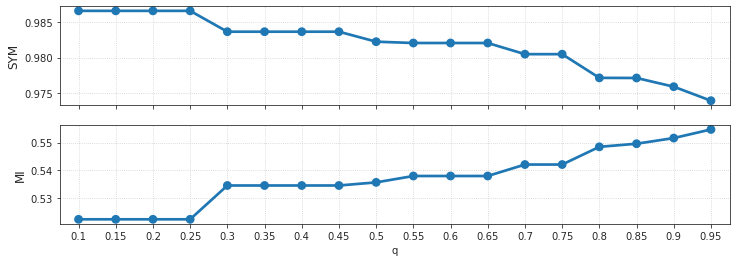

In [111]:
fig, axes = create_figure(2, 1, (12, 4), sharex='all')
sns.pointplot(data=df.loc[df['label'] == 'sym'], x='q', y='value', ax=axes[0])
sns.pointplot(data=df.loc[df['label'] == 'mi'], x='q', y='value', ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('SYM', fontsize=12)
axes[1].set_ylabel('MI', fontsize=12)
add_grid(axes)
plt.show()

In [112]:
mi = df_tx.loc[df_tx['metric'] == 'mi', 'score'].values
sym = df_tx.loc[df_tx['metric'] == 'sym', 'score'].values
sym_iso = df_tx.loc[df_tx['metric'] == 'sym_iso', 'score'].values

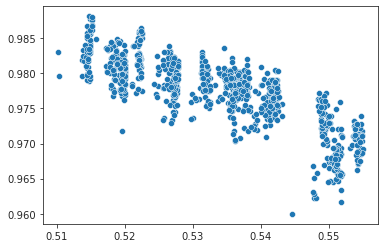

In [113]:
sns.scatterplot(mi, sym);

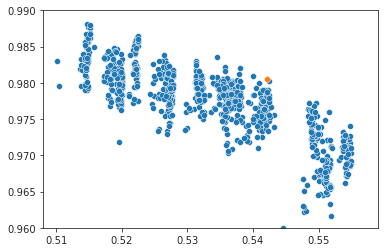

In [114]:
fig, ax = create_figure(1, 1)
sns.scatterplot(mi, sym, ax=ax)
sns.scatterplot(
    [best_df.loc[best_df['metric'] == 'mi', 'score'].item()],
    [best_df.loc[best_df['metric'] == 'sym', 'score'].item()],
    color='C1', ax=ax)
ax.set(xlim=(0.508, 0.559), ylim=(0.96, 0.99))
plt.show()

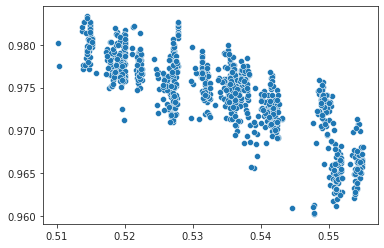

In [115]:
sns.scatterplot(mi, sym_iso);

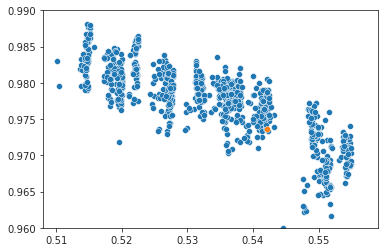

In [116]:
fig, ax = create_figure(1, 1)
sns.scatterplot(mi, sym, ax=ax)
sns.scatterplot(
    [best_df.loc[best_df['metric'] == 'mi', 'score'].item()],
    [best_df.loc[best_df['metric'] == 'sym_iso', 'score'].item()],
    color='C1', ax=ax)
ax.set(xlim=(0.508, 0.559), ylim=(0.96, 0.99))
plt.show()

## Chack quality

In [91]:
tx, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.nissl,
    interpolation='linear',
)
warped = ants.apply_transforms(
    fixed=reg.nissl,
    moving=affined,
    transformlist=tx,
    interpolator='linear',
)

# save warped
warped_file = [
    reg.in_house_name,
    f"space-{reg.space}{reg.dim}",
    'T1w',
]
warped_file = '_'.join(warped_file)
warped_file += '.nii.gz'
warped_file = pjoin(
    reg.mice.cfg.warped_dir, warped_file)
ants.image_write(warped, warped_file)

In [94]:
# save Nissl and Template

f = pjoin(mice.cfg.warped_dir, f'nissl{mice.cfg.resolution}.nii.gz')
if not os.path.isfile(f):
    ants.image_write(reg.nissl, f)

f = pjoin(mice.cfg.warped_dir, f'template{mice.cfg.resolution}.nii.gz')
if not os.path.isfile(f):
    ants.image_write(reg.img_in_ccf(mice.al.template, float), f)

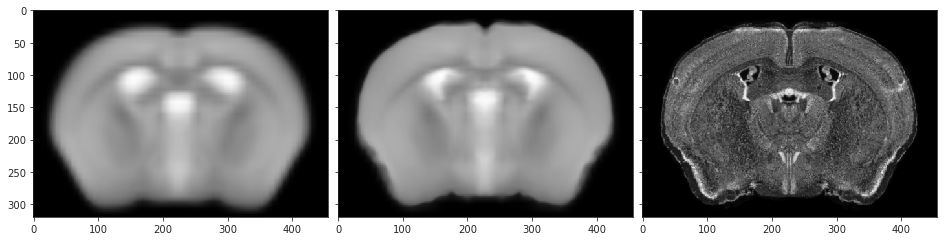

In [97]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
axes[0].imshow(affined[240], cmap='Greys_r')
axes[1].imshow(warped[240], cmap='Greys_r')
axes[2].imshow(reg.nissl[240], cmap='Greys_r')
plt.show()

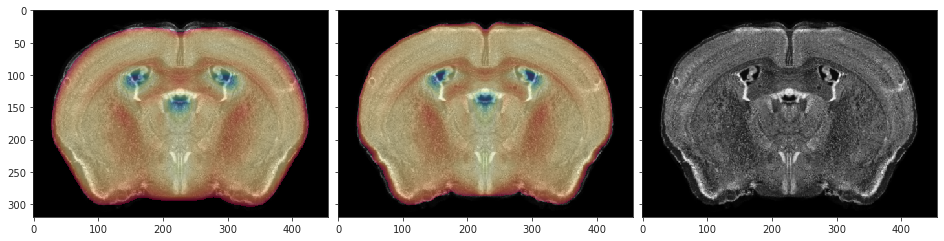

In [99]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.nissl[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
# axes[2].imshow(reg.nissl[60], cmap='Greys_r')
plt.show()

In [100]:
mi_base = ants.image_mutual_information(reg.nissl, reg.nissl)
mi_aff = ants.image_mutual_information(reg.nissl, affined)
mi_syn = ants.image_mutual_information(reg.nissl, warped)

mi_aff /= mi_base
mi_syn /= mi_base

mi_aff, mi_syn

(0.4176205159348757, 0.5420958884644422)

## Now choose the other one (lower MI, but higher Sym)

In [140]:
best_params, best_df = _bst_tx(reg.in_house_name, df_tx, 0.27)
best_df.loc[best_df['metric'].isin(['mi', 'sym', 'sym_iso'])]

,seed,syn_metric,aff_metric,type,grad,syn_bin,aff_bin,aff_rate,metric,score
12636,2,mattes,mattes,ElasticSyN,0.3,48,20,0.4,mi,0.526422
12660,2,mattes,mattes,ElasticSyN,0.3,48,20,0.4,sym_iso,0.978181
12661,2,mattes,mattes,ElasticSyN,0.3,48,20,0.4,sym,0.983854


In [141]:
best_params

{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

In [142]:
kwargs = {
    'types': ['ElasticSyN'],
    'grads': [0.30],
    'syn_bins': [48],
    'aff_bins': [20],
    'aff_rates': [0.2, 0.4],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.25,
    'n_seeds': 20,
}
kwargs

{
    'types': ['ElasticSyN'],
    'grads': [0.3],
    'syn_bins': [48],
    'aff_bins': [20],
    'aff_rates': [0.2, 0.4],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.25,
    'n_seeds': 20
}

In [144]:
reg.set_mode('bold')
reg.mi_base = None

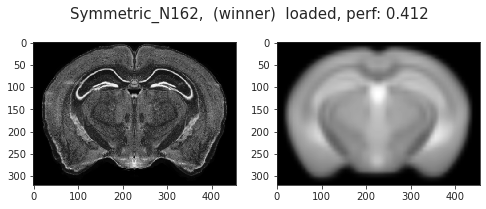

Symmetric_N162, perf:

 seed syn_metric aff_metric       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4       mi 0.526804
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_MOp 0.999074
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_MOp 0.985294
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_MOs 0.997598
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_MOs 0.963836
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4   ovp_SS 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4   sym_SS 0.980978
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 ovp_VISC 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 sym_VISC 0.991597
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_VIS 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_VIS 0.972743
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4   ovp_AI 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4   sym_AI 0.992736
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 ovp_PTLp 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 sym_PTLp 0.920000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_TEa 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_TEa 0.968992
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_CA1 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_CA1 0.997921
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_CLA 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_CLA 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 ovp_STRd 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4 sym_STRd 1.000000
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  ovp_iso 0.999555
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4  sym_iso 0.978016
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4      sym 0.983586
    1     mattes     mattes ElasticSyN   0.3       48       20       0.4      ovp 0.999661

CPU times: user 1d 20h 48min 38s, sys: 59min 55s, total: 1d 21h 48min 34s
Wall time: 3h 4min 39s


In [145]:
%%time

results = reg.fit_register(
    name=reg.in_house_name,
    moving=reg.in_house,
    fixed=reg.nissl,
    save_results=True,
    **kwargs,
)

## --- Here see if elastic was better

In [146]:
tx, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.nissl,
    interpolation='linear',
)
warped = ants.apply_transforms(
    fixed=reg.nissl,
    moving=affined,
    transformlist=tx,
    interpolator='linear',
)

# save warped
warped_file = [
    reg.in_house_name,
    f"space-{reg.space}{reg.dim}",
    'T1w',
]
warped_file = '_'.join(warped_file)
warped_file += '.nii.gz'
warped_file = pjoin(
    reg.mice.cfg.warped_dir, warped_file)
ants.image_write(warped, warped_file)

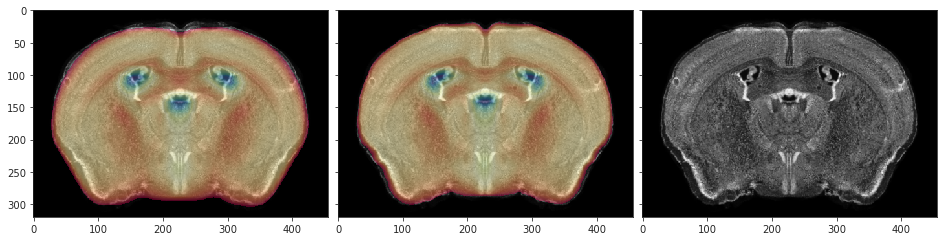

In [164]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.nissl[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
plt.show()

In [173]:
mi_base = ants.image_mutual_information(reg.nissl, reg.nissl)
mi_aff = ants.image_mutual_information(reg.nissl, affined)
mi_syn = ants.image_mutual_information(reg.nissl, warped)

mi_aff /= mi_base
mi_syn /= mi_base

mi_aff, mi_syn

(0.4176205159348757, 0.5268036276196726)

In [165]:
mice.al(['fiber tracts', 'VS', 'Isocortex'])

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
5,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
1101,fiber tracts,1,1101,1009,fiber tracts,"[997, 1009]","[687527945, 184527634, 167587189, 691663206]","[204, 204, 204]"
1292,VS,1,1292,73,ventricular systems,"[997, 73]",[691663206],"[170, 170, 170]"


In [166]:
mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)
mask.shape

(528, 320, 456)

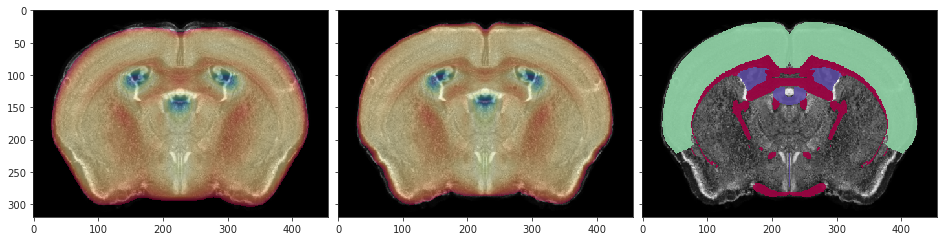

In [172]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.nissl[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
axes[2].imshow(mwh(mask[240] == 0, mask[240]), alpha=0.9, cmap='Spectral_r')
plt.show()

<matplotlib.image.AxesImage object at 0x7f841f8612b0>

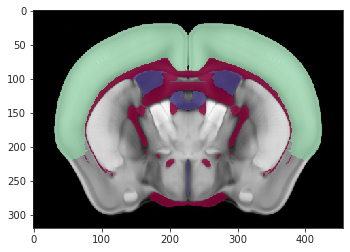

In [184]:
plt.imshow(mice.al.template[240], cmap='Greys_r')
plt.imshow(mwh(mask[240] == 0, mask[240]), alpha=0.7, cmap='Spectral_r')

## Fit template

In [9]:
kwargs = {
    'types': ['SyN', 'ElasticSyN'],
    'grads': [0.30, 0.7],
    'syn_bins': [48],
    'aff_bins': [20, 32],
    'aff_rates': [0.2, 0.4],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.25,
    'n_seeds': 10,
}
kwargs

{
    'types': ['SyN', 'ElasticSyN'],
    'grads': [0.3, 0.7],
    'syn_bins': [48],
    'aff_bins': [20, 32],
    'aff_rates': [0.2, 0.4],
    'aff_metric': ['mattes'],
    'syn_metric': ['mattes'],
    'mi_q': 0.25,
    'n_seeds': 10
}

In [10]:
reg.set_mode('bold')
reg.mi_base = None

 bad det -1 v -1 u 1
 bad det -1 v -1 u 1 new 1


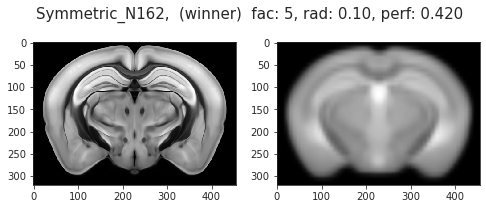

Symmetric_N162, perf:

 seed syn_metric aff_metric       type  grad  syn_bin  aff_bin  aff_rate   metric    score
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2       mi 0.551089
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_MOp 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_MOp 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_MOs 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_MOs 0.993912
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2   ovp_SS 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2   sym_SS 0.998637
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 ovp_VISC 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 sym_VISC 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_VIS 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_VIS 0.996790
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2   ovp_AI 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2   sym_AI 0.997475
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 ovp_PTLp 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 sym_PTLp 0.950980
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_TEa 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_TEa 0.969925
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_CA1 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_CA1 0.997963
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_CLA 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_CLA 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 ovp_STRd 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2 sym_STRd 0.997508
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  ovp_iso 1.000000
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2  sym_iso 0.996201
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2      sym 0.996062
    2     mattes     mattes ElasticSyN   0.3       48       20       0.2      ovp 1.000000

CPU times: user 9d 9h 42min 18s, sys: 4h 27min 39s, total: 9d 14h 9min 58s
Wall time: 13h 52min 33s


In [12]:
%%time

results = reg.fit_register(
    name=reg.in_house_name,
    moving=reg.in_house,
    fixed=reg.template,
    save_results=True,
    **kwargs,
)

In [15]:
tx, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)
warped = ants.apply_transforms(
    fixed=reg.template,
    moving=affined,
    transformlist=tx,
    interpolator='linear',
)

# save warped
warped_file = [
    reg.in_house_name,
    f"space-{reg.space}{reg.dim}",
    'T1w',
]
warped_file = '_'.join(warped_file)
warped_file += '.nii.gz'
warped_file = pjoin(
    reg.mice.cfg.warped_dir, warped_file)
ants.image_write(warped, warped_file)

In [16]:
mi_base = ants.image_mutual_information(reg.template, reg.template)
mi_aff = ants.image_mutual_information(reg.template, affined)
mi_syn = ants.image_mutual_information(reg.template, warped)

mi_aff /= mi_base
mi_syn /= mi_base

mi_aff, mi_syn

(0.4280764509142616, 0.551089256337447)

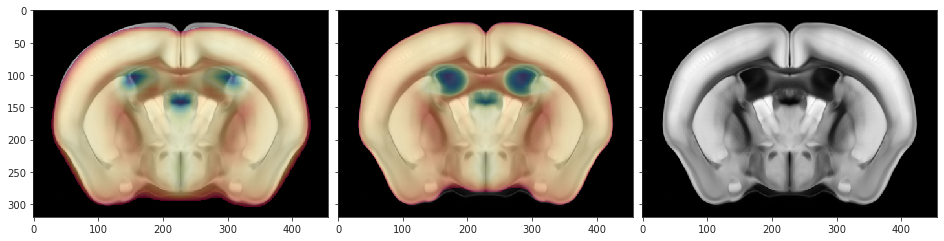

In [17]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
plt.show()

In [18]:
mice.al(['fiber tracts', 'VS', 'Isocortex'])

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
5,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
1101,fiber tracts,1,1101,1009,fiber tracts,"[997, 1009]","[687527945, 184527634, 167587189, 691663206]","[204, 204, 204]"
1292,VS,1,1292,73,ventricular systems,"[997, 73]",[691663206],"[170, 170, 170]"


In [19]:
mask = mice.al.get_masks(['fiber tracts', 'VS', 'Isocortex'], as_objectmap=True)
mask.shape

(528, 320, 456)

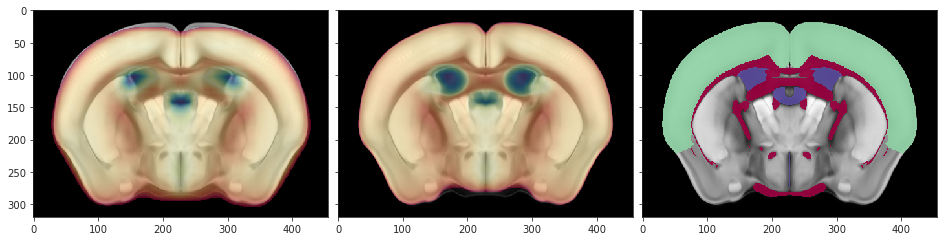

In [20]:
fig, axes = create_figure(1, 3, (13, 6), 'all', 'all', constrained_layout=True)
for i in range(3):
    axes[i].imshow(reg.template[240], cmap='Greys_r')
axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(warped[240] < 4000, warped[240]), alpha=0.5, cmap='Spectral')
axes[2].imshow(mwh(mask[240] == 0, mask[240]), alpha=0.9, cmap='Spectral_r')
plt.show()

In [21]:
tx, tx_aff = reg.load_tx(reg.in_house_name, is_inv=True)
tx_aff_inv = tx_aff.invert()

In [47]:
obj = ants.apply_transforms(
    fixed=affined,
    moving=reg.img_in_ccf(mask),
    transformlist=tx,
    interpolator='genericLabel',
)
obj = tx_aff_inv.apply_to_image(
    image=obj,
    reference=reg.in_house,
    interpolation='multilabel',
)

In [48]:
obj = obj.numpy()
for i_new, i in enumerate(np.unique(obj[obj.nonzero()])):
    obj[obj == i] = i_new + 1

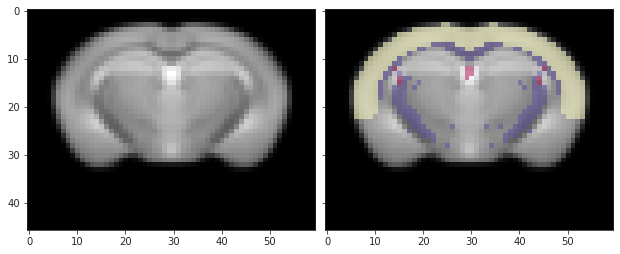

In [50]:
fig, axes = create_figure(1, 2, (8.5, 6), 'all', 'all', constrained_layout=True)
for i in range(2):
    axes[i].imshow(reg.in_house[40], cmap='Greys_r')
#axes[0].imshow(mwh(affined[240] < 4000, affined[240]), alpha=0.5, cmap='Spectral')
axes[1].imshow(mwh(obj[40] == 0, obj[40]), alpha=0.5, cmap='Spectral', vmin=1, vmax=3)
#axes[2].imshow(mwh(mask[240] == 0, mask[240]), alpha=0.9, cmap='Spectral_r')
plt.show()

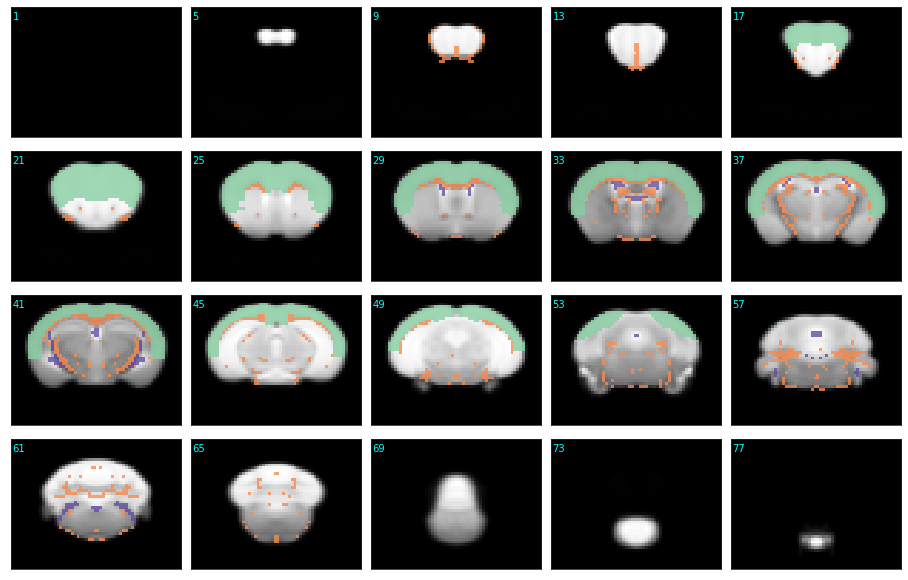

In [79]:
slices = range(1, 81, 4)

ncols = 5
nrows = int(np.ceil(len(slices) / ncols))
fig, axes = create_figure(nrows, ncols, (ncols * 2.5, nrows * 2), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.annotate(
        text=s_,
        xy=(0.01, 0.9),
        xycoords='axes fraction',
        color='cyan',
    )
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
    ax.imshow(mwh(obj[s_] == 0, obj[s_]), alpha=0.8, vmin=1.5, vmax=3.5, cmap='Spectral_r')
remove_ticks(axes, False)
plt.show()

<matplotlib.image.AxesImage object at 0x7fdb0076cb80>

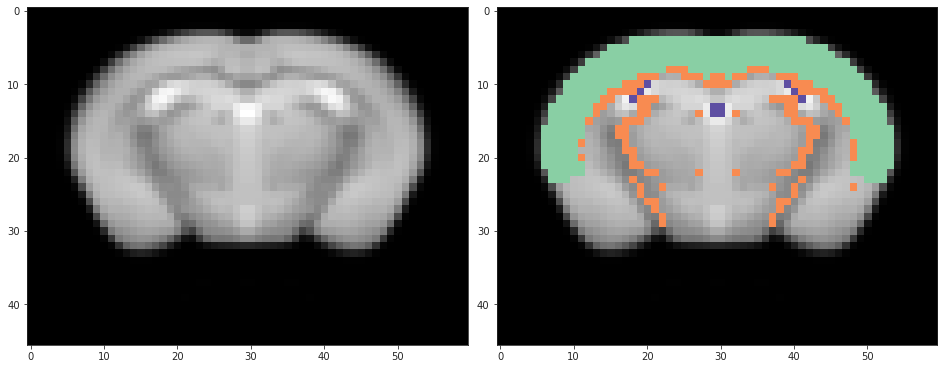

In [97]:
fig, axes = create_figure(1, 2, (13, 5), constrained_layout=True)
s_ = 37
for ax in axes.flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, vmin=1.5, vmax=3.5, cmap='Spectral_r')

In [99]:
df = results['df'].loc[results['df']['metric'].isin(['mi', 'sym'])]
df = df.pivot_table(
    values='score',
    columns='metric',
    index=[c for c in df.columns if c not in ['score', 'metric']],
).reset_index()

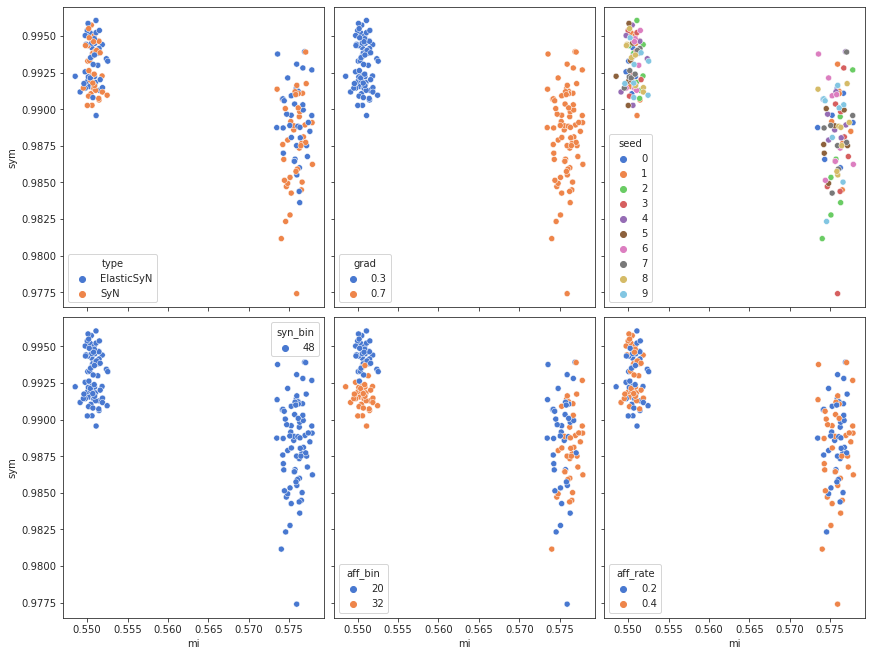

In [100]:
fig, axes = create_figure(2, 3, (12, 9), 'all', 'all', constrained_layout=True)
sns.scatterplot(data=df, x='mi', y='sym', hue='type', palette='muted', ax=axes[0, 0])
sns.scatterplot(data=df, x='mi', y='sym', hue='grad', palette='muted', ax=axes[0, 1])
sns.scatterplot(data=df, x='mi', y='sym', hue='seed', palette='muted', ax=axes[0, 2])
sns.scatterplot(data=df, x='mi', y='sym', hue='syn_bin', palette='muted', ax=axes[1, 0])
sns.scatterplot(data=df, x='mi', y='sym', hue='aff_bin', palette='muted', ax=axes[1, 1])
sns.scatterplot(data=df, x='mi', y='sym', hue='aff_rate', palette='muted', ax=axes[1, 2])

plt.show()

In [101]:
def _bst_tx(name, df_tx, mi_q, verbose=False):
    mi = df_tx.loc[df_tx['metric'] == 'mi']
    sym = df_tx.loc[df_tx['metric'] == 'sym']
    mi = mi.reset_index(drop=True)
    sym = sym.reset_index(drop=True)
    cond = mi['score'] > np.nanquantile(mi['score'], mi_q)
    _df = sym.loc[cond]
    try:
        best_params = _df.iloc[_df['score'].argmax()]
    except ValueError:
        cond = mi['score'] > np.nanquantile(mi['score'], 2 * mi_q / 3)
        _df = sym.loc[cond]
        best_params = _df.iloc[_df['score'].argmax()]
    best_params = best_params.drop(['metric', 'score'])
    best_params = dict(best_params)
    cond = functools.reduce(
        lambda x, y: x & y, [
            df_tx[k] == v for k, v
            in best_params.items()
        ],
    )
    _df = df_tx.loc[cond]
    if verbose:
        msg = f"{name}, perf:\n\n"
        msg += f"{_df.to_string(index=False)}\n"
        print(msg)
    return best_params, _df

In [102]:
best_params, best_df = _bst_tx(reg.in_house_name, results['df'], 0.75)
best_df.loc[best_df['metric'].isin(['mi', 'sym', 'sym_iso'])]

,seed,syn_metric,aff_metric,type,grad,syn_bin,aff_bin,aff_rate,metric,score
2052,4,mattes,mattes,ElasticSyN,0.7,48,20,0.2,mi,0.576900
2076,4,mattes,mattes,ElasticSyN,0.7,48,20,0.2,sym_iso,0.992873
2077,4,mattes,mattes,ElasticSyN,0.7,48,20,0.2,sym,0.993927


In [104]:
df = []
for q in np.linspace(0.1, 0.95, 18):
    best_params, _df = _bst_tx(reg.in_house_name, results['df'], q, False)
    mi = _df.loc[_df['metric'] == 'mi', 'score'].item()
    sym = _df.loc[_df['metric'] == 'sym', 'score'].item()
    data = {
        'mi': mi,
        'sym': sym,
        **best_params,
    }
    print(f"q = {q:0.2f};  mi = {mi:0.3f}, sym = {sym:0.3f}", best_params)
    df.append({
        'q': [np.round(q, 2)] * len(data),
        'label': data.keys(),
        'value': data.values(),
    })
df = pd.DataFrame(merge_dicts(df))

q = 0.10;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.15;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.20;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.25;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.30;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.35;  mi = 0.551, sym = 0.996
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.40;  mi = 0.552, sym = 0.995
{
    'seed': 6,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.45;  mi = 0.552, sym = 0.994
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.3,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.4
}

q = 0.50;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.55;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.60;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.65;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.70;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.75;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.80;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.85;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.90;  mi = 0.577, sym = 0.994
{
    'seed': 4,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 20,
    'aff_rate': 0.2
}

q = 0.95;  mi = 0.578, sym = 0.993
{
    'seed': 2,
    'syn_metric': 'mattes',
    'aff_metric': 'mattes',
    'type': 'ElasticSyN',
    'grad': 0.7,
    'syn_bin': 48,
    'aff_bin': 32,
    'aff_rate': 0.4
}

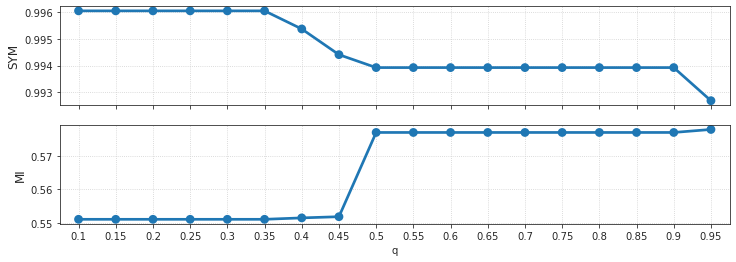

In [105]:
fig, axes = create_figure(2, 1, (12, 4), sharex='all')
sns.pointplot(data=df.loc[df['label'] == 'sym'], x='q', y='value', ax=axes[0])
sns.pointplot(data=df.loc[df['label'] == 'mi'], x='q', y='value', ax=axes[1])
axes[0].set_xlabel('')
axes[0].set_ylabel('SYM', fontsize=12)
axes[1].set_ylabel('MI', fontsize=12)
add_grid(axes)
plt.show()

## Save objects

In [88]:
tx, tx_aff = reg.load_tx(reg.in_house_name)

obj = reg._apply_tx_obj2lps(
    name=reg.in_house_name,
    moving=affined,
    moving_orig=reg.in_house,
    tx_aff=tx_aff,
    tx=tx,
    use_mm=True,
    save_results=True,
)

In [90]:
list(obj)

[
    'cols',
    'cortex',
    'cortex-top',
    'subcortex-l',
    'subcortex-r',
    'subcortex',
    'CH',
    'brain',
    'misc',
    'iso',
    'hemis'
]

In [127]:
obj['cols']

ANTsImage (RAI)
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [140]:
in_house = reg.load_in_house()
in_house

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (60, 46, 81)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7f7750dde7f0>

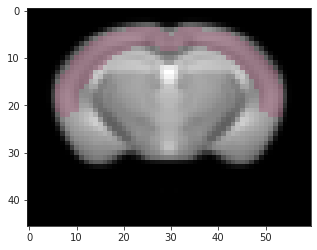

In [165]:
x2p = obj['cols'].numpy()
x2p = mwh(x2p == 0, x2p)

plt.imshow(in_house[..., 40].T, cmap='Greys_r')
plt.imshow(x2p[..., 40].T > 0, cmap='Spectral', alpha=0.2)

<matplotlib.image.AxesImage object at 0x7f7750e89790>

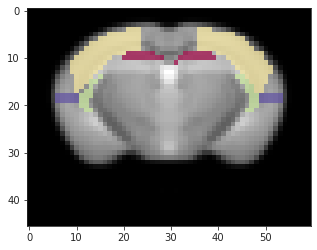

In [163]:
x2p = obj['misc'].numpy()
x2p = mwh(x2p == 0, x2p)

plt.imshow(in_house[..., 40].T, cmap='Greys_r')
plt.imshow(x2p[..., 40].T , cmap='Spectral', alpha=0.7)

In [166]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

In [ ]:
brain_mask = []
for f in files:
    x = ants.image_read(pjoin(mice.cfg.raw_dir, f))
    x = x.numpy()[:, :, 40, :]
    brain_mask.append(np.abs(x).sum(-1) > 0)

In [173]:
mask_all = functools.reduce(np.logical_or, brain_mask)
mask_all = mask_all.T[::-1][:, ::-1]
mask_all.shape

(46, 60)

<matplotlib.image.AxesImage object at 0x7f7767e55ac0>

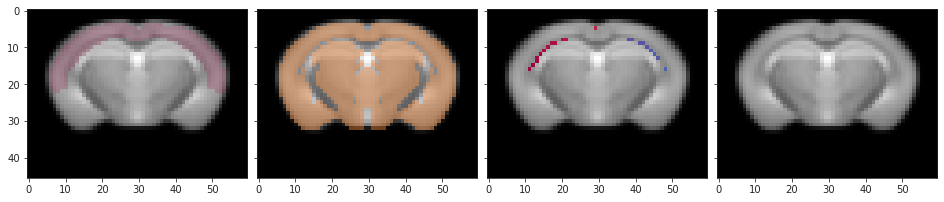

In [201]:
x2p = obj['cols'].numpy()
x2p = mwh(x2p == 0, x2p)
x2p = x2p[..., 40].T 

fig, axes = create_figure(1, 4, (13, 3), 'all', 'all', constrained_layout=True)

for i in range(4):
    axes[i].imshow(in_house[..., 40].T, cmap='Greys_r')

axes[0].imshow(x2p > 0, cmap='Spectral', alpha=0.2)
axes[1].imshow(mwh(mask_all == 0, mask_all), cmap='Oranges', vmin=0, vmax=2, alpha=0.4)
axes[2].imshow(mwh(~np.logical_and(~mask_all, x2p > 0), x2p), cmap='Spectral')
axes[3].imshow(mwh(~np.logical_and(mask_all > 0, x2p == 0), x2p), cmap='Spectral')

In [205]:
np.logical_and(mask_all > 0, x2p == 0).sum(), np.logical_and(mask_all == 0, x2p != 0).sum()

(0, 21)

In [206]:
overlap_score(mask_all, x2p > 0)

0.9278350515463918